# import & data load系

In [72]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
from scipy import stats

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# 統計モデル
import statsmodels.api as sm

# Prophet <- 要install
from fbprophet import Prophet
import sys,os
sys.path.append(os.pardir)

In [40]:
from DataReader import DataReader
dr = DataReader()
train_df, test_df = dr.get_raw_data()

# トレーニングデータから欠損値とclose=1を除く

In [41]:
train_df = train_df[train_df.close==0]
train_df = train_df[train_df.price_am!=-1]
train_df = train_df[train_df.price_pm!=-1]

In [42]:
df = train_df[["datetime", "y"]]
df["ds"] = pd.to_datetime(df.datetime)
df = df.drop("datetime", axis=1)
df = df.reset_index()
df.head()

/Users/tatsukikoga/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,index,y,ds
0,187,16,2011-01-04
1,188,16,2011-01-05
2,189,13,2011-01-06
3,190,14,2011-01-07
4,191,16,2011-01-08


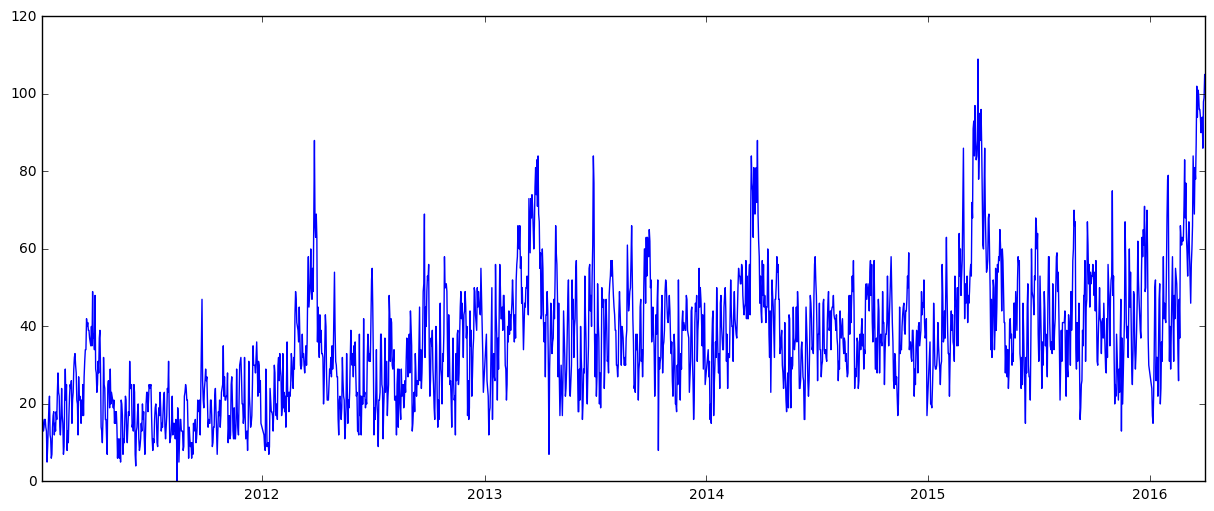

In [43]:
plt.plot(df.ds, df.y)

In [57]:
event_df_train = pd.DataFrame({
  'holiday': 'client_train',
  'ds': train_df[train_df.client == 1].datetime,
})
event_df_test = pd.DataFrame({
  'holiday': 'client_test',
  'ds': test_df[test_df.client == 1].datetime,
})

event_df = pd.concat((event_df_train, event_df_test))

def march_weekend(ds):
    date = pd.to_datetime(ds)
    if date.weekday() >= 5 and date.month == 3:
        return 1
    else:
        return 0
    
df['march_weekend'] = df['ds'].apply(march_weekend)

m = Prophet(weekly_seasonality=True, yearly_seasonality=True, holidays=event_df)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=10)
m.add_regressor('march_weekend', prior_scale=50)

m.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=365)
future['march_weekend'] = future['ds'].apply(march_weekend)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
2249,2017-03-27,87.970430,77.376144,98.086916
2250,2017-03-28,85.103635,75.171512,95.378165
2251,2017-03-29,85.315318,74.889914,94.705542
2252,2017-03-30,86.593680,75.522919,96.291778
2253,2017-03-31,90.350878,80.235475,100.604361


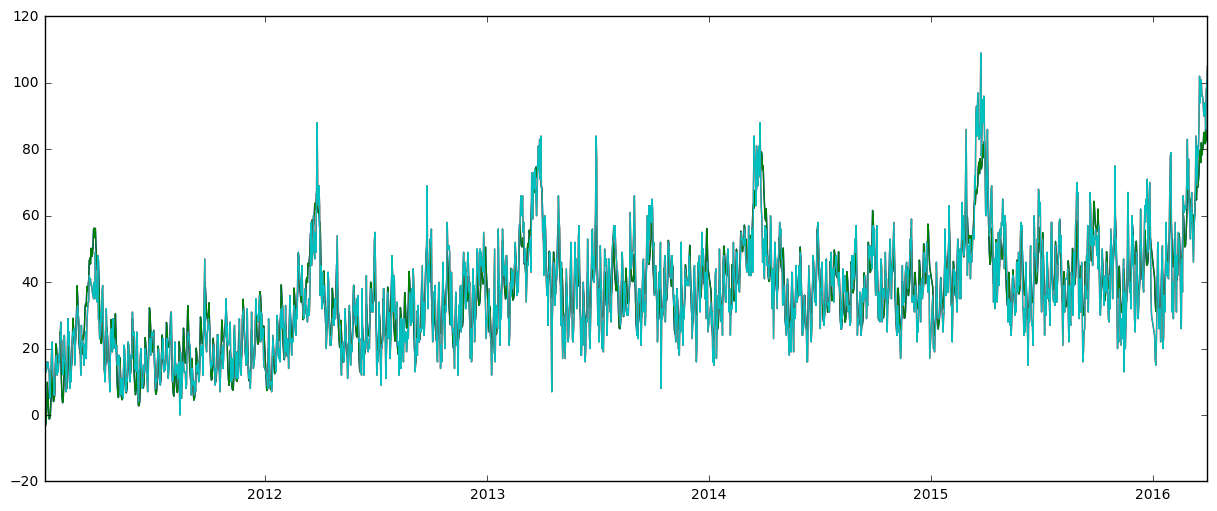

In [58]:
train_ans = forecast[:1889]
train_ans = train_ans.reset_index()
train_ans_ = pd.concat([train_ans, df], axis=1)
train_ans_["y_diff"] = train_ans_.y - train_ans_.yhat
plt.plot(train_ans_.ds, train_ans_.yhat)
plt.plot(train_ans_.ds, train_ans_.y)

In [59]:
# plt.plot(train_ans_.ds, train_ans_.y_diff)
train_ans_[["y", "yhat", "y_diff", "ds"]].head()

,y,yhat,y_diff,ds,ds
0,16,-2.722386,18.722386,2011-01-04,2011-01-04
1,16,-3.175804,19.175804,2011-01-05,2011-01-05
2,13,-2.212996,15.212996,2011-01-06,2011-01-06
3,14,1.813889,12.186111,2011-01-07,2011-01-07
4,16,9.846986,6.153014,2011-01-08,2011-01-08


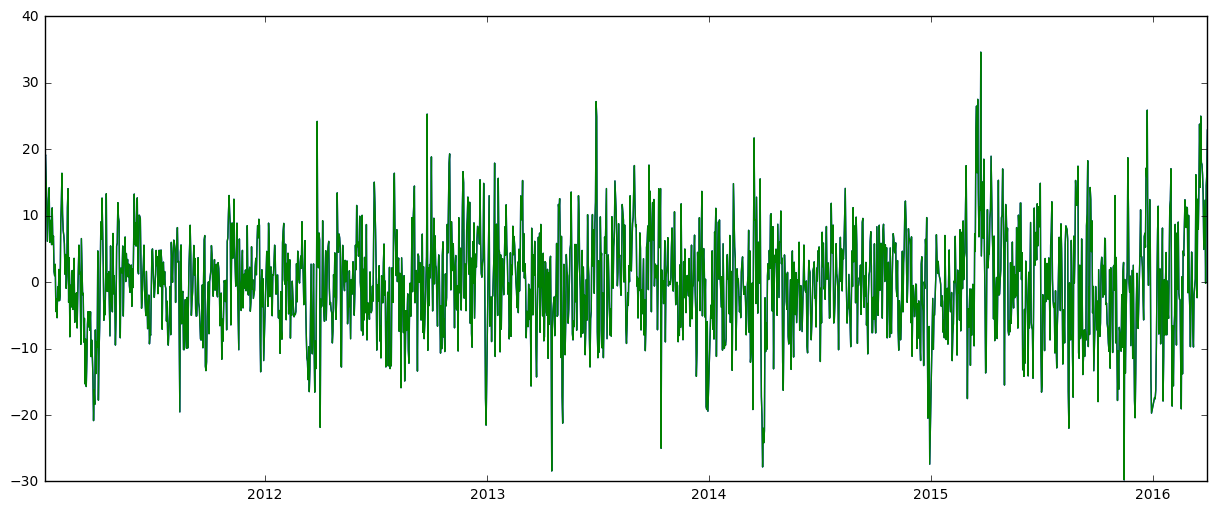

In [60]:
plt.plot(train_ans_.ds, train_ans_.y_diff)

# trainでのMAE

In [61]:
sum(abs(train_ans_.y - train_ans_.yhat)) / len(train_ans_)

5.9041032455538494

In [62]:
forecast[forecast.ds=='2016-04-01']

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,client_test,client_test_lower,client_test_upper,client_train,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
1889,2016-04-01,49.209818,49.209818,49.209818,72.210184,92.011123,0.0,0.0,0.0,0.0,...,32.961774,32.961774,32.961774,0.065892,0.065892,0.065892,23.993748,23.993748,23.993748,82.171592


In [63]:
ans = forecast[1889:]
len(ans) == len(test_df)

True

In [64]:
ans = ans.reset_index()
test_df = test_df.reset_index()

In [65]:
ans_ = pd.concat([ans, test_df], axis=1)
ans_

,index,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,client_test,client_test_lower,client_test_upper,...,yearly_lower,yearly_upper,yhat,level_0,index,datetime,client,close,price_am,price_pm
0,1889,2016-04-01,49.209818,49.209818,49.209818,72.210184,92.011123,0.0,0.0,0.0,...,23.993748,23.993748,82.171592,0,0,2016-04-01,1,0,3,2
1,1890,2016-04-02,49.224448,49.224448,49.224448,77.273632,96.031037,0.0,0.0,0.0,...,22.348289,22.348289,86.802146,1,1,2016-04-02,0,0,5,5
2,1891,2016-04-03,49.239079,49.239079,49.239079,69.383177,89.256115,0.0,0.0,0.0,...,20.643337,20.643337,79.183166,2,2,2016-04-03,1,0,2,2
3,1892,2016-04-04,49.253709,49.253709,49.253709,59.591587,78.864677,0.0,0.0,0.0,...,18.901321,18.901321,68.864910,3,3,2016-04-04,1,0,1,1
4,1893,2016-04-05,49.268339,49.268339,49.268339,51.207785,70.539961,0.0,0.0,0.0,...,17.144548,17.144548,60.586572,4,4,2016-04-05,0,0,1,1
5,1894,2016-04-06,49.282969,49.282969,49.282969,45.020829,64.966829,0.0,0.0,0.0,...,15.394784,15.394784,55.471248,5,5,2016-04-06,1,0,1,1
6,1895,2016-04-07,49.297600,49.297600,49.297600,43.114318,62.789513,0.0,0.0,0.0,...,13.672842,13.672842,52.561367,6,6,2016-04-07,1,0,1,1
7,1896,2016-04-08,49.312230,49.312230,49.312230,44.225135,63.847913,0.0,0.0,0.0,...,11.998203,11.998203,54.159287,7,7,2016-04-08,0,0,1,1
8,1897,2016-04-09,49.326860,49.326860,49.326860,51.719249,71.235088,0.0,0.0,0.0,...,10.388669,10.388669,60.966901,8,8,2016-04-09,1,0,2,2
9,1898,2016-04-10,49.341490,49.341490,49.341490,46.962695,66.691104,0.0,0.0,0.0,...,8.860066,8.860066,56.741135,9,9,2016-04-10,1,0,1,1


In [66]:
ans_['y_'] = (1 - ans_['close']) * ans_['yhat'] 

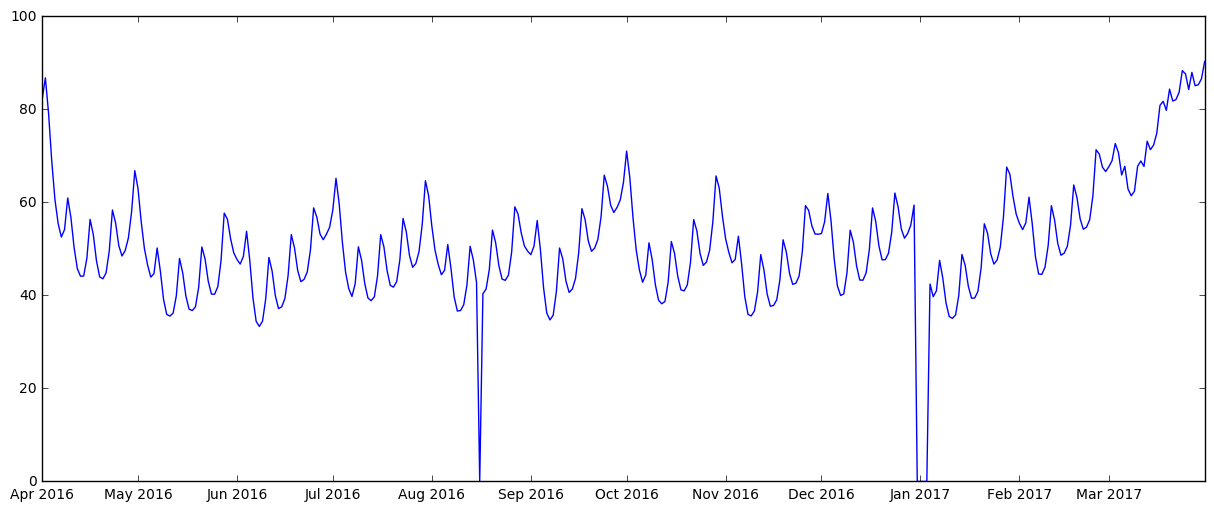

In [67]:
plt.plot(ans_.ds, ans_.y_)

In [68]:
print(ans_[ans_.client==1].y_.mean(), ans_[ans_.client==0].y_.mean())
print(train_df[train_df.client==1].y.mean(), train_df[train_df.client==0].y.mean())

53.185266137497976 49.00231911170099
50.577669902912625 34.57100415923945


In [71]:
submission = pd.concat([ans_.ds, ans_.y_], axis=1)
submission.to_csv("../data/submission.csv", index=False, header=False)

# 最新のsubmission score
-> 11.070203595200000

# 現状の問題点
- clientの情報がうまく取り込めていない？
- 周期性が強すぎる <- これはしょうがない気がする
    - アンサンブルすべき